In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import torch
import torchaudio
from tqdm import tqdm
import librosa

from IPython.display import Audio

tqdm.pandas()

## huggingface packages
from datasets import Dataset, ClassLabel
import evaluate

In [2]:
mps_device = torch.device("mps")

In [3]:
cv_train_tab = pd.read_csv('./cv-archive/cv-valid-train.csv')
cv_test_tab = pd.read_csv('./cv-archive/cv-valid-test.csv')

print(cv_train_tab.shape)
print(cv_test_tab.shape)

cv_train_tab = cv_train_tab.dropna(subset=['accent'])
cv_test_tab = cv_test_tab.dropna(subset=['accent'])

print(cv_train_tab.shape)
print(cv_test_tab.shape)

cv_train_tab.head()

(195776, 8)
(3995, 8)
(64711, 8)
(1338, 8)


,filename,text,up_votes,down_votes,age,gender,accent,duration
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN


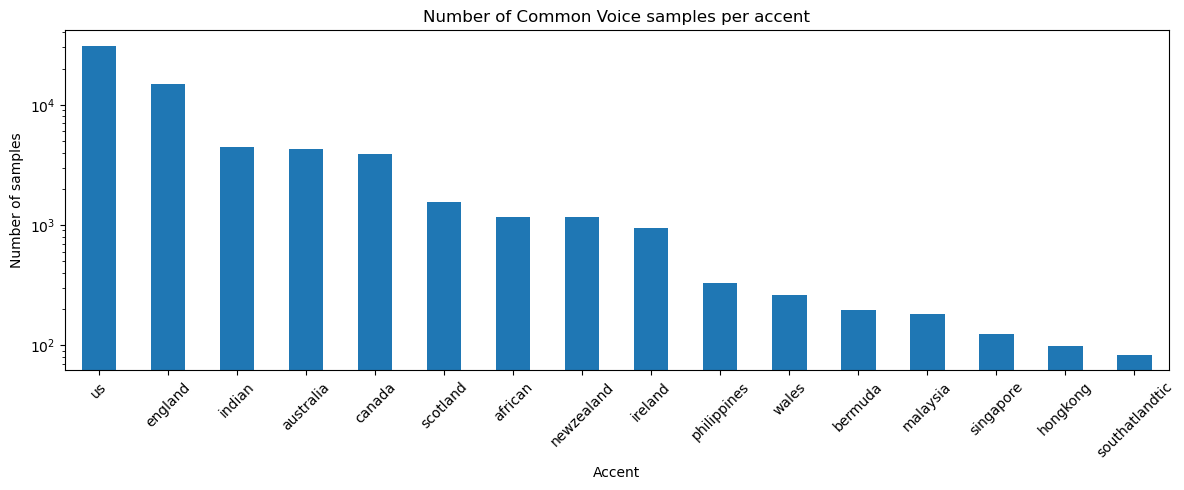

In [4]:
plt.figure(figsize=(12,5))

cv_train_tab['accent'].value_counts().plot.bar(rot=45)
plt.yscale('log')
plt.ylabel('Number of samples')
plt.xlabel('Accent')
plt.title('Number of Common Voice samples per accent')
plt.tight_layout()
plt.savefig('./pictures/cv_accents_bar.png',format='png')
plt.show()

In [5]:
cv_test_tab.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of pe...,4,0,twenties,male,us,NaN
5,cv-valid-test/sample-000005.mp3,down below in the darkness were hundreds of pe...,4,1,twenties,male,us,NaN
8,cv-valid-test/sample-000008.mp3,this was the strangest of all things that ever...,1,0,thirties,male,england,NaN
9,cv-valid-test/sample-000009.mp3,it was glaringly hot not a cloud in the sky no...,3,0,fifties,male,us,NaN
14,cv-valid-test/sample-000014.mp3,follow the instructions here,1,0,twenties,male,scotland,NaN


In [6]:
CORES = multiprocessing.cpu_count() # Count the number of cores in a computer
print(CORES)

12


In [7]:
multiprocessing.set_start_method('fork')

def f(x): 
    return x + 1 

with multiprocessing.Pool() as pool: 
    print(pool.map(f, range(10))) 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [8]:
def add_path_train(filename):
    path_to_train = './cv-archive/cv-valid-train/'
    if path_to_train not in filename:
        filename = path_to_train+filename
    return(filename)

cv_train_tab['filename'] = cv_train_tab.filename.apply(add_path_train) 
cv_train_tab.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
5,./cv-archive/cv-valid-train/cv-valid-train/sam...,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
8,./cv-archive/cv-valid-train/cv-valid-train/sam...,put jackie right on the staff,3,0,seventies,male,us,NaN
13,./cv-archive/cv-valid-train/cv-valid-train/sam...,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
14,./cv-archive/cv-valid-train/cv-valid-train/sam...,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN
19,./cv-archive/cv-valid-train/cv-valid-train/sam...,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN


In [9]:
def add_path_test(filename):
    path_to_test = './cv-archive/cv-valid-test/'
    if path_to_test not in filename:
        filename = path_to_test+filename
    return(filename)

cv_test_tab['filename'] = cv_test_tab.filename.apply(add_path_test) 
cv_test_tab.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
3,./cv-archive/cv-valid-test/cv-valid-test/sampl...,down below in the darkness were hundreds of pe...,4,0,twenties,male,us,NaN
5,./cv-archive/cv-valid-test/cv-valid-test/sampl...,down below in the darkness were hundreds of pe...,4,1,twenties,male,us,NaN
8,./cv-archive/cv-valid-test/cv-valid-test/sampl...,this was the strangest of all things that ever...,1,0,thirties,male,england,NaN
9,./cv-archive/cv-valid-test/cv-valid-test/sampl...,it was glaringly hot not a cloud in the sky no...,3,0,fifties,male,us,NaN
14,./cv-archive/cv-valid-test/cv-valid-test/sampl...,follow the instructions here,1,0,twenties,male,scotland,NaN


## length check

In [10]:
def pull_metadata(filename):
  try:
    metadata = torchaudio.info(filename)
    length = metadata.num_frames / metadata.sample_rate
    return(length)
  except:
    return(float('NaN'))

print(cv_test_tab.iloc[0].filename)

metadata = pull_metadata(cv_train_tab.iloc[0].filename)
print(metadata)

./cv-archive/cv-valid-test/cv-valid-test/sample-000003.mp3
5.836125


/opt/anaconda3/lib/python3.12/site-packages/torchaudio/_backend/soundfile_backend.py:71: UserWarning: The MPEG_LAYER_III subtype is unknown to TorchAudio. As a result, the bits_per_sample attribute will be set to 0. If you are seeing this warning, please report by opening an issue on github (after checking for existing/closed ones). You may otherwise ignore this warning.
  warnings.warn(


In [11]:
pool = multiprocessing.Pool(CORES)
train_lengths = pool.map(pull_metadata, cv_train_tab.filename)
test_lengths = pool.map(pull_metadata, cv_test_tab.filename)
pool.close()

In [12]:
index_meta, = np.where(~np.isnan(train_lengths))
index_nometa,= np.where(np.isnan(train_lengths))

print(len(index_meta),len(index_nometa))

train_lengths = np.array(train_lengths)
test_lengths = np.array(test_lengths)

64711 0


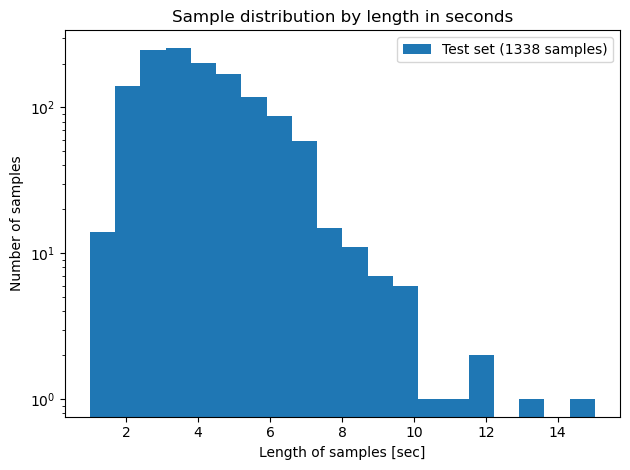

15.028125


In [13]:
plt.hist(test_lengths,bins=20,
         label='Test set ('+str(len(test_lengths))+' samples)')
plt.yscale('log')
plt.ylabel('Number of samples')
plt.xlabel('Length of samples [sec]')
plt.title('Sample distribution by length in seconds')
plt.legend()
plt.tight_layout()
plt.savefig('./pictures/cv_test_length_hist.png',format='png')
plt.show()

print(np.max(test_lengths))

64711 64699


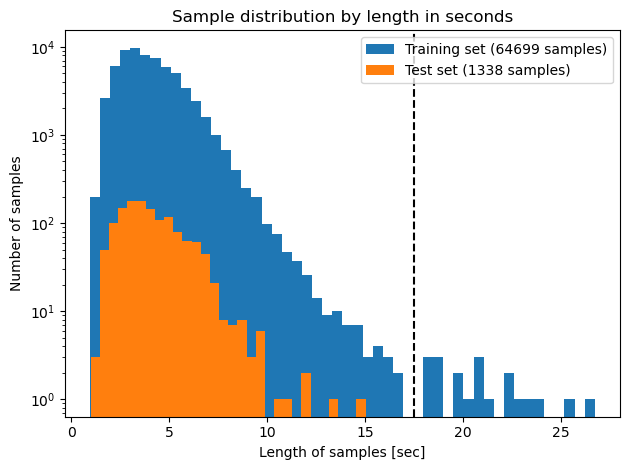

In [14]:
index_long, = np.where(train_lengths < 30)

print(len(index_meta),len(index_long))

plt.hist(train_lengths[index_long],bins=50,
         label='Training set ('+str(len(train_lengths[index_long]))+\
         ' samples)')
plt.hist(test_lengths,bins=30,
         label='Test set ('+str(len(test_lengths))+' samples)')

CUTOFF = 17.5

plt.axvline(CUTOFF,ls='--',color='k')

plt.yscale('log')

plt.ylabel('Number of samples')
plt.xlabel('Length of samples [sec]')
plt.title('Sample distribution by length in seconds')
plt.legend()
plt.tight_layout()
plt.savefig('./pictures/cv_train_length_hist.png',format='png')
plt.show()

In [15]:
if 'length' not in cv_train_tab:
    cv_train_tab['length'] = train_lengths

cv_test_tab['length'] = test_lengths

print(cv_train_tab.shape)
print(cv_train_tab[cv_train_tab.length<CUTOFF].shape)

cv_train_tab = cv_train_tab[cv_train_tab.length<CUTOFF]

cv_train_tab.head()

(64711, 9)
(64679, 9)


,filename,text,up_votes,down_votes,age,gender,accent,duration,length
5,./cv-archive/cv-valid-train/cv-valid-train/sam...,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN,5.836125
8,./cv-archive/cv-valid-train/cv-valid-train/sam...,put jackie right on the staff,3,0,seventies,male,us,NaN,1.732125
13,./cv-archive/cv-valid-train/cv-valid-train/sam...,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN,4.228125
14,./cv-archive/cv-valid-train/cv-valid-train/sam...,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN,5.380125
19,./cv-archive/cv-valid-train/cv-valid-train/sam...,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN,3.740125


## quality control

In [16]:
print(cv_train_tab[cv_train_tab.down_votes>0].shape)
print(cv_train_tab[cv_train_tab.down_votes==0].shape)
print(cv_train_tab[cv_train_tab.up_votes>cv_train_tab.down_votes].shape)

print(cv_test_tab[cv_test_tab.down_votes==0].shape)

(5419, 9)
(59260, 9)
(64669, 9)
(1217, 9)


In [17]:
cv_train_tab = cv_train_tab[cv_train_tab.down_votes==0]
cv_test_tab = cv_test_tab[cv_test_tab.down_votes==0]

print(cv_train_tab.shape,cv_test_tab.shape)

(59260, 9) (1217, 9)


In [18]:
ACCENTS = ['us','england','scotland','australia','ireland','canada']#,'wales',]
ACCENTS = ['england','scotland','australia','ireland','canada']

print(cv_train_tab[cv_train_tab.accent.isin(ACCENTS)].shape)
print(cv_train_tab.shape)

print(cv_test_tab[cv_test_tab.accent.isin(ACCENTS)].shape)
print(cv_test_tab.shape)

(23731, 9)
(59260, 9)
(506, 9)
(1217, 9)


In [19]:
cv_train_tab = cv_train_tab[cv_train_tab.accent.isin(ACCENTS)]
cv_test_tab = cv_test_tab[cv_test_tab.accent.isin(ACCENTS)]

In [20]:
label2id, id2label = dict(), dict()
for i, label in enumerate(ACCENTS):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

cv_train_tab['label'] = cv_train_tab['accent'].apply(lambda x: label2id[x])
cv_test_tab['label'] = cv_test_tab['accent'].apply(lambda x: label2id[x])

cv_train_tab.head()

{0: 'england', 1: 'scotland', 2: 'australia', 3: 'ireland', 4: 'canada'} 

 {'england': 0, 'scotland': 1, 'australia': 2, 'ireland': 3, 'canada': 4}


,filename,text,up_votes,down_votes,age,gender,accent,duration,length,label
14,./cv-archive/cv-valid-train/cv-valid-train/sam...,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN,5.380125,0
19,./cv-archive/cv-valid-train/cv-valid-train/sam...,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN,3.740125,2
26,./cv-archive/cv-valid-train/cv-valid-train/sam...,two years ago right here on this spot i had a ...,4,0,twenties,female,australia,NaN,4.996125,2
27,./cv-archive/cv-valid-train/cv-valid-train/sam...,don't let them see that you're afraid the alch...,3,0,twenties,male,australia,NaN,3.508125,2
44,./cv-archive/cv-valid-train/cv-valid-train/sam...,they were people of the desert and clamored to...,2,0,thirties,male,england,NaN,10.900125,0


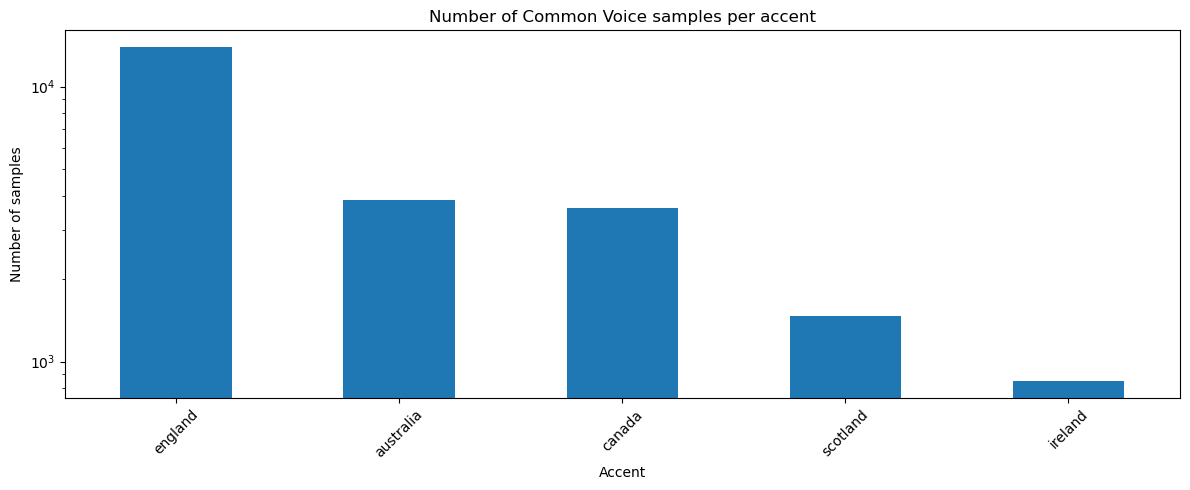

In [21]:
plt.figure(figsize=(12,5))

cv_train_tab['accent'].value_counts().plot.bar(rot=45)
plt.yscale('log')
plt.ylabel('Number of samples')
plt.xlabel('Accent')
plt.title('Number of Common Voice samples per accent')
plt.tight_layout()
plt.show()

In [22]:
import sklearn
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced', classes=np.array(ACCENTS), y=cv_train_tab['accent'])
class_weights = dict(zip(ACCENTS, weights))
print(class_weights)

{'england': 0.34086469405343295, 'scotland': 3.2508219178082194, 'australia': 1.2257747933884298, 'ireland': 5.590341578327444, 'canada': 1.3089354660783232}


In [23]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

rus = RandomUnderSampler(random_state=83, sampling_strategy='auto')
# ros = RandomOverSampler(random_state=83, sampling_strategy='all')
y = cv_train_tab['label']
cv_train_tab_rus = cv_train_tab.drop(['label'], axis=1)
cv_train_tab_rus, y_resampled = rus.fit_resample(cv_train_tab, y)
del y
cv_train_tab_rus['label'] = y_resampled
del y_resampled

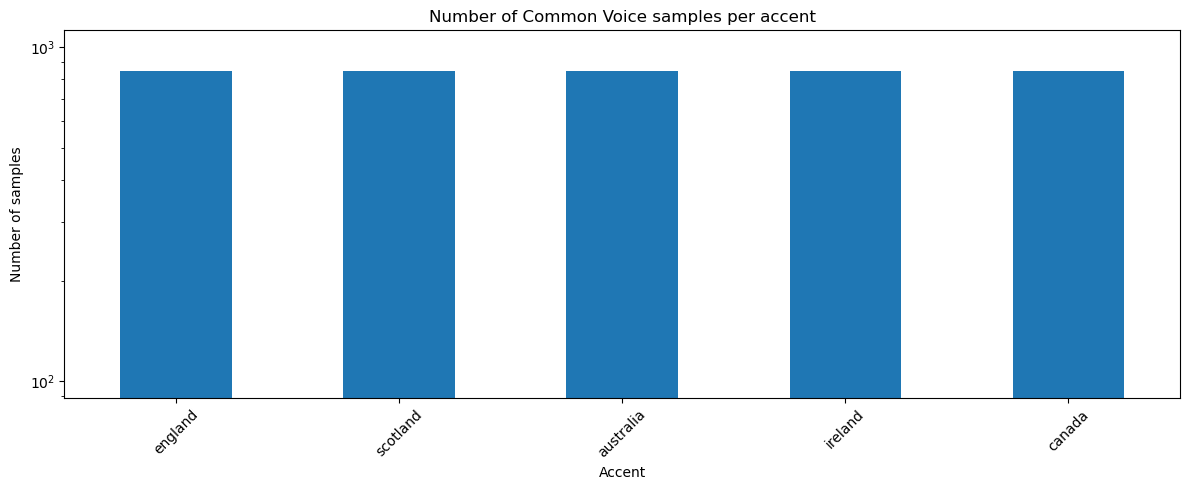

In [24]:
plt.figure(figsize=(12,5))

cv_train_tab_rus['accent'].value_counts().plot.bar(rot=45)
plt.yscale('log')
plt.ylabel('Number of samples')
plt.xlabel('Accent')
plt.title('Number of Common Voice samples per accent')
plt.tight_layout()
plt.show()

In [25]:
weights = compute_class_weight(class_weight='balanced', classes=np.array(ACCENTS), y=cv_train_tab['accent'])
class_weights = dict(zip(ACCENTS, weights))
print(class_weights)

{'england': 0.34086469405343295, 'scotland': 3.2508219178082194, 'australia': 1.2257747933884298, 'ireland': 5.590341578327444, 'canada': 1.3089354660783232}


In [26]:
cv_train_tab = cv_train_tab_rus

# looking at the data

In [35]:
lookat_file = cv_test_tab.iloc[3]
lookat_file

filename      ./cv-archive/cv-valid-test/cv-valid-test/sampl...
text          some of the grey ash was falling off the circu...
up_votes                                                      3
down_votes                                                    0
age                                                    twenties
gender                                                     male
accent                                                  england
duration                                                    NaN
length                                                 4.060125
label                                                         0
Name: 22, dtype: object

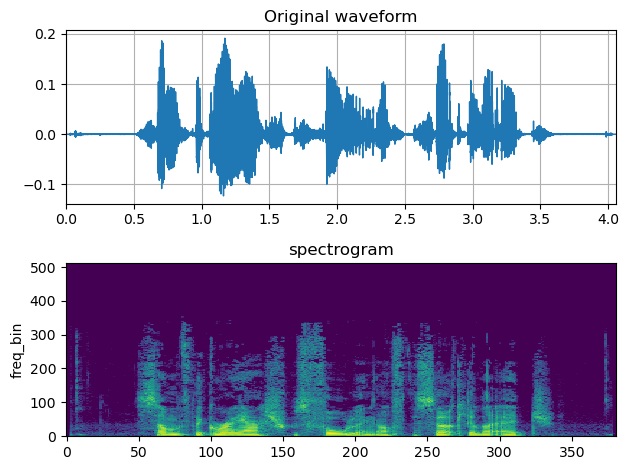

In [55]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    
waveform, sample_rate = torchaudio.load(lookat_file.filename)

NFFT = 1024
spectrogram = torchaudio.transforms.Spectrogram(n_fft=NFFT,power=2)

# Perform transform
spec = spectrogram(waveform)

fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sample_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

Audio(waveform.numpy()[0], rate=sample_rate)


In [56]:
griffin_lim = torchaudio.transforms.GriffinLim(n_fft=NFFT,power=2)
recon_waveform = griffin_lim(spec)

Audio(recon_waveform.numpy()[0], rate=sample_rate)

## resampling function

In [ ]:
RESAMPLE_RATE = 16000

def resample_audio(file):
    audio, rate = torchaudio.load(str(file))
    
    transform = torchaudio.transforms.Resample(rate, RESAMPLE_RATE)
    audio_prime = transform(audio).squeeze(0).numpy().reshape(-1)
        
    return(audio_prime)

In [ ]:
test_file = cv_test_tab.iloc[0].filename

audio_prime = resample_audio(test_file)
print(audio_prime)

print(len(audio_prime),len(waveform.numpy()[0]))

Audio(audio_prime, rate=RESAMPLE_RATE)

In [ ]:
from speechbrain.inference import EncoderClassifier

# Load the ECAPA-TDNN based accent classifier
classifier = EncoderClassifier.from_hparams(
    source="Jzuluaga/accent-id-commonaccent_ecapa",
    savedir="pretrained_models/accent-id-ecapa"
)

# Classify the audio
out_prob, score, index, text_lab = classifier.classify_file(test_file)

# Print results
print(f"Predicted Accent: {text_lab[0]}")

In [ ]:
def classify_pretrained(file):
    out_prob, score, index, text_lab = classifier.classify_file(file)
    return(text_lab[0])

pool = multiprocessing.Pool(CORES)
predict_accent = []
for result in tqdm(pool.imap_unordered(classify_pretrained, cv_test_tab.filename), total=len(cv_test_tab.filename)):
    predict_accent.append(result)
pool.close()

In [ ]:
print(f"accuracy: {np.sum(predict_accent == cv_test_tab.accent)/len(cv_test_tab.filename)}")

# getting data ready for training using Datasets

In [ ]:
# pool = multiprocessing.Pool(CORES)
# audio_prime_test = []
# for result in tqdm(pool.imap_unordered(resample_audio, cv_test_tab.filename), total=len(cv_test_tab.filename)):
#     audio_prime_test.append(result)
# audio_prime_train = []
# for result in tqdm(pool.imap_unordered(resample_audio, cv_train_tab.filename), total=len(cv_train_tab.filename)):
#     audio_prime_train.append(result)
# pool.close()

# cv_train_tab['audio'] = audio_prime_train
# cv_test_tab['audio'] = audio_prime_test
# del audio_prime_test

In [ ]:
# dataset = Dataset.from_pandas(cv_train_tab[['audio','label']])
# # dataset = Dataset.from_pandas(cv_test_tab[['audio','label']])

# ClassLabels = ClassLabel(num_classes=len(ACCENTS), names=ACCENTS)

# # Mapping labels to IDs
# def map_label2id(example):
#     example['label'] = ClassLabels.str2int(example['label'])
#     return example

# dataset = dataset.map(map_label2id, batched=True)

# # Casting label column to ClassLabel Object
# dataset = dataset.cast_column('label', ClassLabels)

# dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label")

# dataset = dataset.with_format("torch", device=mps_device)

# print(len(dataset['test']))

# using anusha's model

In [ ]:
max_duration = CUTOFF
sample_rate = 16000

class AccentDataset:
    def __init__(self, df, sample_rate=sample_rate, max_duration=max_duration):
        self.df = df.copy(deep=True)
        self.sample_rate = sample_rate
        self.max_length = int(sample_rate * max_duration)  # e.g., 5 seconds
        self.label_encoder = LabelEncoder()
        self.df['accent'] = self.label_encoder.fit_transform(df['accent'])
        self.accent_id = dict(enumerate(self.label_encoder.classes_))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['filename']
        label = row['accent']

        # Load audio
        wav, sr = torchaudio.load(path)

        # Resample if needed
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            wav = resampler(wav)

        # Remove channel dimension
        wav = wav.squeeze(0)

        # Truncate or pad as needed
        num_samples = self.max_length
        if wav.shape[0] > num_samples:
            wav = wav[:num_samples]
        elif wav.shape[0] < num_samples:
            pad_len = num_samples - wav.shape[0]
            wav = torch.nn.functional.pad(wav, (0, pad_len))

        # return torch.tensor(wav, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        return wav.detach().clone().requires_grad_(True), torch.tensor(label, dtype=torch.long)

In [ ]:
# Split data into training and validation
num_train = int(0.8 * len(cv_train_tab))
num_val = len(cv_train_tab) - num_train

print(num_train,num_val)

In [ ]:
import torch.nn as nn
from torch.utils.data import random_split
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

train_df, val_df = train_test_split(
    cv_train_tab,
    test_size=0.2,
    stratify=cv_train_tab['accent'],  # ensures all classes are represented
    random_state=42
)

train_ds = AccentDataset(train_df)
val_ds = AccentDataset(val_df)

# Dataloaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=True)
dls = DataLoaders(train_dl, val_dl)

# Set up model
features = 2**6 # runs out of RAM >2**10
data_dim = int(sample_rate*max_duration)
num_countries = len(set(cv_train_tab['accent']))

simple_net = nn.Sequential(
            nn.Linear(data_dim, features),
            nn.ReLU(),
            nn.Linear(features, num_countries)
        )

playful_net = nn.Sequential(
            nn.Linear(data_dim, 256),
            nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(256, num_countries)
        )

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=CrossEntropyLossFlat(), metrics=[accuracy])
# learn.recorder.train_metrics = True
learn.recorder.valid_metrics = True
learn.fit(5) # argument in parentheses is number of epoch
    

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(L(learn.recorder.values).itemgot(2))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f"Final accuracy: {learn.recorder.values[-1][2]}")

In [ ]:
test_ds = AccentDataset(cv_test_tab)
test_dl = DataLoader(test_ds, batch_size=16)
preds, _ = learn.get_preds(dl=test_dl)
pred_classes = preds.argmax(dim=1)

In [ ]:
[print(int(pred_classes[i]), list(test_ds.df['accent'])[i]) for i in range(len(pred_classes))];

# using the accent classifier model

In [ ]:
import transformers

from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

model_str = "facebook/wav2vec2-base-960h" 
model_str = "dima806/english_accents_classification"
feature_extractor=AutoFeatureExtractor.from_pretrained(model_str)
model=AutoModelForAudioClassification.from_pretrained(model_str,num_labels=len(ACCENTS))
model.config.id2label = id2label

In [ ]:
def preprocess_function(batch):
    inputs = feature_extractor(batch['audio'], sampling_rate=RESAMPLE_RATE)
    inputs['input_values'] = inputs['input_values'][0]
    return inputs

dataset['train'] = dataset['train'].map(preprocess_function, batched=False,remove_columns='audio')
dataset['test'] = dataset['test'].map(preprocess_function, batched=False,remove_columns='audio')

In [ ]:
dataset = dataset.with_format("torch", device=mps_device)

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

from sklearn.metrics import (
    accuracy_score,  # For calculating accuracy
    roc_auc_score,   # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)
def compute_metrics(eval_pred):
    # Compute the ROC AUC score
    predictions = eval_pred.predictions
    predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    roc_auc = roc_auc_score(label_ids, predictions, average='macro', multi_class='ovr')
    
    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']
    
    return {
        "roc_auc": roc_auc,
        "accuracy": acc_score
    }

# def compute_metrics(eval_pred):
#     predictions = eval_pred.predictions.argmax(axis=-1)
#     return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
torch.backends.mps.is_available()

In [ ]:
from transformers import TrainingArguments, Trainer
batch_size=8
warmup_steps=50
weight_decay=0.02
num_train_epochs=1
model_name = "accents_classifier"
training_args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate= 3e-5,
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1,
    eval_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    eval_steps=1,
    gradient_accumulation_steps=1, 
    gradient_checkpointing=True,
    save_strategy='epoch',
    save_total_limit=1,# save fewer checkpoints to limit used space
    dataloader_pin_memory=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=feature_extractor,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.evaluate()

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
outputs = trainer.predict(dataset["test"])

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

In [ ]:
import itertools

y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
    # Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred) # normalize='true'

# Plot the confusion matrix using the defined function
plot_confusion_matrix(cm, ACCENTS, figsize=(8, 6), is_norm=False)

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=ACCENTS, digits=4))